In [1]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
#from evaluation_functions import *
from functions_ import *
from plotting import *
from Bio import SeqIO
import matplotlib.patches as patches
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [2]:
## reload the evaluation functions
from importlib import reload 
import plotting
reload(plotting)
from plotting import *
import functions_
reload(functions_)
from functions_ import *

In [3]:
translate_dna2aa("cgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcg".upper())

'RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV'

In [3]:
### define the necessary variables

base_dir = os.getcwd() 

catch_left = ''
catch_right = ''

Barcodes = {"BC1_fwd": "CCC", 
            "BC1_rev" : "CCC", 
            "BC2_fwd":	"AAA",
            "BC2_rev":	"AAA", 
            "BC3_fwd":	"TTT",
            "BC3_rev":	"TTT",}

Primer_seq = {"_fwd": "cgccgCATGGAAGCGAT".upper(),
              "_rev":"cgcacgCGGTTATCCATCG".upper()}

Primer_out_of_triplets = {"_fwd": 0, 
                          "_rev": 2}
amplicon_seq = "cgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcg".upper()

amplicon_AA = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

LOV2_prot = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"


genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [253]:
variant = "R36"
BCs_per_var = {"R35": ["BC1", "BC2"],
               "R36": ["BC1", "BC2", "BC3"],
               }

In [254]:

### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',] 
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']
ref_gene = amplicon_seq

used_BCs = BCs_per_var[variant]

filter_for_n_mut = False# True
read_len_treshold = None#(40,40)

## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities, base_dir = os.getcwd()+ "/data/fastq/R36"
)

all_reads, all_ids = demultiplex_reads(a_seq, b_seq, ref_gene = ref_gene ,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = used_BCs, Sections = [""], max_mismatch_primerseq = 5, filter_for_n_mut = filter_for_n_mut, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= read_len_treshold, Primer_out_of_triplets= Primer_out_of_triplets, cut_primer_start=True, cut_BC_seq=True)


#### settings
amplicon_DNA = amplicon_seq[:-2]
amplicon_AA = translate_dna2aa(amplicon_DNA)

### set parameters
base_dir = os.getcwd()
name = variant
FigFolder =f"{base_dir}/output/{name}/R1-R2"
use_rev_read = True
use_forward_read = True
arbitrary_cutoff_a = False
arbitrary_cutoff_b = False

if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

total reads 85274
[3, 5, 6, 11, 12, 14, 18, 20, 23, 24]
41699
2324 b reads are empty
702 a reads are empty
34446 forward reads with matching BC and primer seq
15012 reads with index swapping
BC1  34446 reads before filtering
################# Done: BC1 
################# Done: BC1
[0, 1, 2, 4, 7, 8, 9, 10, 15, 17]
26509
1951 b reads are empty
209 a reads are empty
21158 forward reads with matching BC and primer seq
13269 reads with index swapping
BC2  21158 reads before filtering
################# Done: BC2 
################# Done: BC2
[13, 16, 19, 21, 22, 31, 41, 44, 56, 71]
11759
852 b reads are empty
85 a reads are empty
8452 forward reads with matching BC and primer seq
7610 reads with index swapping
BC3  8452 reads before filtering
################# Done: BC3 
################# Done: BC3


In [259]:
Bc = "BC3"
seqs = all_reads[f"{Bc}__R1"]

output_file = f"data/fastq/R36/R36_{Bc}_Nt_filt_R1_001.fasta"
sequences = [SeqIO.SeqRecord(Seq(read), id = all_ids[f"{Bc}__R1"][i], description = f"R36 {Bc} DNA sequence") for i, read in enumerate(all_reads[f"{Bc}__R1"])]

count = SeqIO.write(sequences, output_file, "fasta")
with open(output_file, "w") as output_handle:
    SeqIO.write(sequences, output_handle, "fasta")
print("Saved %i records to %s" % (count, output_file))

Saved 8452 records to data/fastq/R36/R36_BC3_Nt_filt_R1_001.fasta


In [7]:
# Bc = "BC2"
# aa_seqs = [translate_dna2aa(read) for read in all_reads[f"{Bc}__R1"]]

# output_file = f"data/fastq/R35/R35_{Bc}_AA_R1_001.fasta"
# sequences = [SeqIO.SeqRecord(Seq(translate_dna2aa(read)), id = all_ids[f"{Bc}__R1"][i], description = f"R35 {Bc} protein sequence") for i, read in enumerate(all_reads[f"{Bc}__R1"]) if len(read) > 3]

# count = SeqIO.write(sequences, output_file, "fasta")
# with open(output_file, "w") as output_handle:
#     SeqIO.write(sequences, output_handle, "fasta")
# print("Saved %i records to %s" % (count, output_file))

Saved 35341 records to data/fastq/R35/R35_BC2_AA_R1_001.fasta


In [32]:
# for key, ids in all_ids.items():
#     print(key, len(ids))
#     Name = "R35"
#     Read_dir = key[-2:]
#     input_file = f"data/fastq/R35/{Name}_{Read_dir}_001.fastq"
#     output_file = f"{Name}_{key}_001.fastq"

#     records = (r for r in SeqIO.parse(input_file, "fastq") if r.id in ids)
#     count = SeqIO.write(records, output_file, "fastq")
#     print("Saved %i records from %s to %s" % (count, input_file, output_file))
#     if count < len(ids):
#         print("Warning %i IDs not found in %s" % (len(ids)-count, input_file))

BC1__R1 28166
Saved 28166 records from data/fastq/R35/R35_R1_001.fastq to R35_BC1__R1_001.fastq
BC1__R2 28166
Saved 28166 records from data/fastq/R35/R35_R2_001.fastq to R35_BC1__R2_001.fastq
BC2__R1 35552
Saved 35552 records from data/fastq/R35/R35_R1_001.fastq to R35_BC2__R1_001.fastq
BC2__R2 35552
Saved 35552 records from data/fastq/R35/R35_R2_001.fastq to R35_BC2__R2_001.fastq


In [256]:
same_bc = 0
diff_bc = 0
for idx, a_read in enumerate(a_seq): 
    if a_read[:3] == b_seq[idx][:3] and a_read[:3] != "":
        same_bc += 1  
    else: 
        diff_bc += 1
        
print("same BC: ", same_bc)
print("idx swapping BC: ", diff_bc)

same BC:  64083
idx swapping BC:  21191


In [218]:
a_seq = all_reads["BC1__R1"]
b_seq = all_reads["BC1__R2"]

In [219]:
data_type = "DNA"
dataType_handler = {"DNA": gather_nt_variants, "Codons": gather_codon_variants, "AA": gather_AA_variants}
gather_variants = dataType_handler.get(data_type)

ref_seq = amplicon_DNA if data_type != "AA" else amplicon_AA

variants = pd.DataFrame.from_dict(gather_variants(a_seq = a_seq, b_seq = b_seq, ref = ref_seq))
variants_counts, variants_prop = mask_ref_in_variants_df(variants, ref_seq = ref_seq, data_type=data_type)

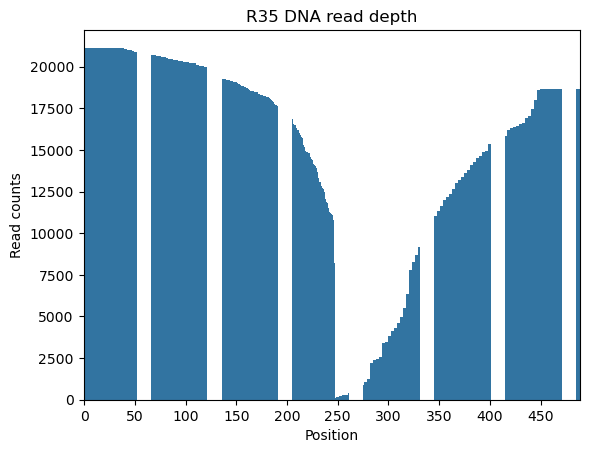

In [220]:
coverage_plot(variants.sum(), FigFolder=FigFolder, samplename=name+ " DNA")

In [221]:
### look specifically at reads with S->L mutation at pos 9 (these reads most likely do not have LOV2 inserted)
LOVstart_idx = amplicon_AA.index("SGLATTLER")
LOVend_idx = len(amplicon_AA) - amplicon_AA.index("DEAAKG") - len("DEAAKG")+1
aa_seqs = [translate_dna2aa(a[len(catch_left):]) if len(a) > len(catch_left) else "" for a in a_seq]
aa_idxs_oi = [a[LOVstart_idx:LOVstart_idx+2] =="LH" if len(a) > LOVstart_idx+1 else False  for a in aa_seqs]
print(sum(aa_idxs_oi), " a reads without LOV2")

aa_seqs_oi = [a for idx, a in enumerate(a_seq) if aa_idxs_oi[idx]]
print(Counter([translate_dna2aa(seq[len(catch_left):]) for seq in aa_seqs_oi]))
### these reads show, that LOV2 is missing (where it should be inserted, the AraC sequence proceeds instead of the LOV2 sequence occuring)

### same for b reads
### look specifically at reads with G->E mutation at pos 9 (these reads most likely do not have LOV2 inserted)
b_aa_seqs = [translate_dna2aa(dna_rev_comp(b[len(catch_right):len(catch_right)+(len(b)-len(catch_right))//3*3]))if len(b) > len(catch_right) else "" for b in b_seq]
b_seqaa_idxs_oi = [b[-LOVend_idx-1:-LOVend_idx+1] =="NE" if len(b) > LOVend_idx else False  for b in b_aa_seqs]
print(sum(b_seqaa_idxs_oi), " b reads without LOV2")

b_aa_seqs_oi = [b for idx, b in enumerate(b_seq) if b_seqaa_idxs_oi[idx]]
print(Counter([translate_dna2aa(dna_rev_comp(seq[len(catch_right):len(catch_right)+(len(seq)-len(catch_right))//3*3])) for seq in b_aa_seqs_oi]))

### exclude these reads 
a_seq = [a for idx, a in enumerate(a_seq) if not aa_idxs_oi[idx]]
b_seq = [b for idx, b in enumerate(b_seq) if not b_seqaa_idxs_oi[idx]]

## recalculate the mut enrichment
seq_variants = {}
seq_variants["AA"] = pd.DataFrame.from_dict(gather_AA_variants(a_seq, b_seq, ref = amplicon_AA, catch_left=catch_left, catch_right=catch_right, use_rev_read=use_rev_read))
if not use_forward_read or not use_rev_read: 
    seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
    
seq_variants["Codons"] = pd.DataFrame.from_dict(gather_codon_variants(a_seq, b_seq, ref = amplicon_DNA, catch_left=catch_left, catch_right=catch_right, use_rev_read=use_rev_read))
if not use_forward_read or not use_rev_read: 
    seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

seq_variants["DNA"] = pd.DataFrame.from_dict(gather_nt_variants(a_seq, b_seq, ref = amplicon_DNA, catch_left=catch_left, catch_right=catch_right, use_rev_read=use_rev_read))
if not use_forward_read or not use_rev_read: 
    seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]

36  a reads without LOV2
Counter({'RRMEAINESLHPP': 36})
106  b reads without LOV2
Counter({'MEAINESLHPPMDNRV': 50, 'AINESLHPPMDNRV': 35, 'EAINESLHPPMDNRV': 17, 'INESLHPPMDNRV': 3, 'TINESLHPPMDNRV': 1})


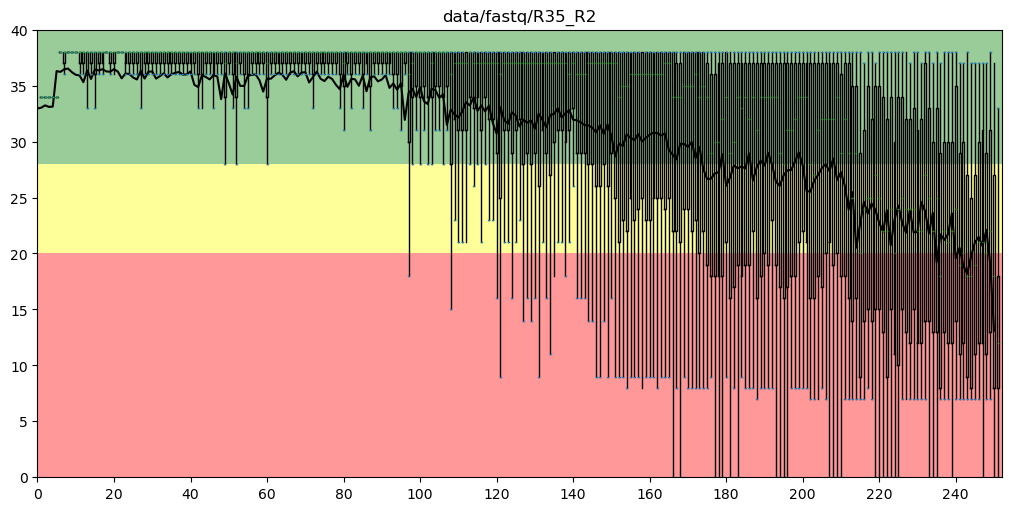

In [214]:
### the code was taken and adapted from ... ####

read_direction = "R2"

fig, axs = plt.subplots(1, 1, figsize=(10, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
filename = f"data/fastq/{variant}_{read_direction}_001.fastq"

fastq_parser = SeqIO.parse(filename, "fastq")
res=[]

for record in fastq_parser:
    score=record.letter_annotations["phred_quality"]
    res.append(score)
df = pd.DataFrame(res)
l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)
df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))

ax.set_xlim((0,l))
ax.set_ylim((0,40))
ax.set_title(filename.split(".")[0][:-4])
plt.savefig(f"{FigFolder}/{read_direction}_quality_scores.pdf", bbox_inches="tight")
plt.show()


<Figure size 640x480 with 0 Axes>

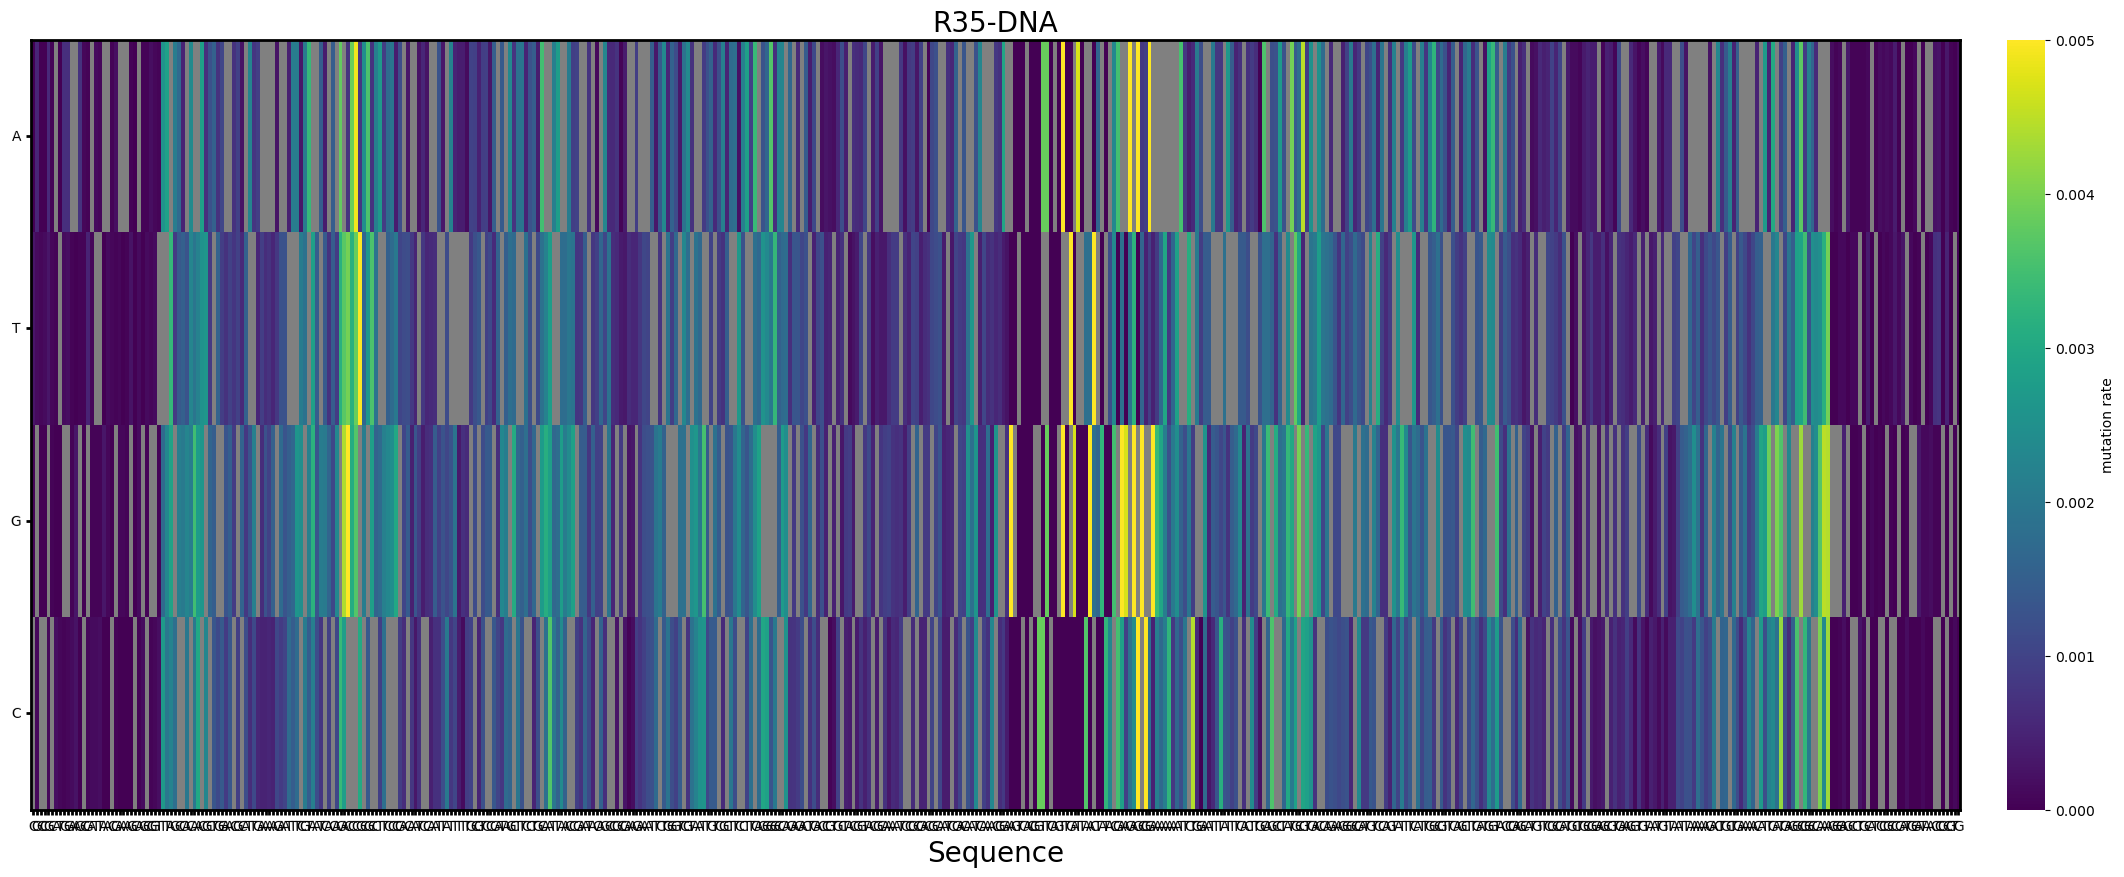

<Figure size 640x480 with 0 Axes>

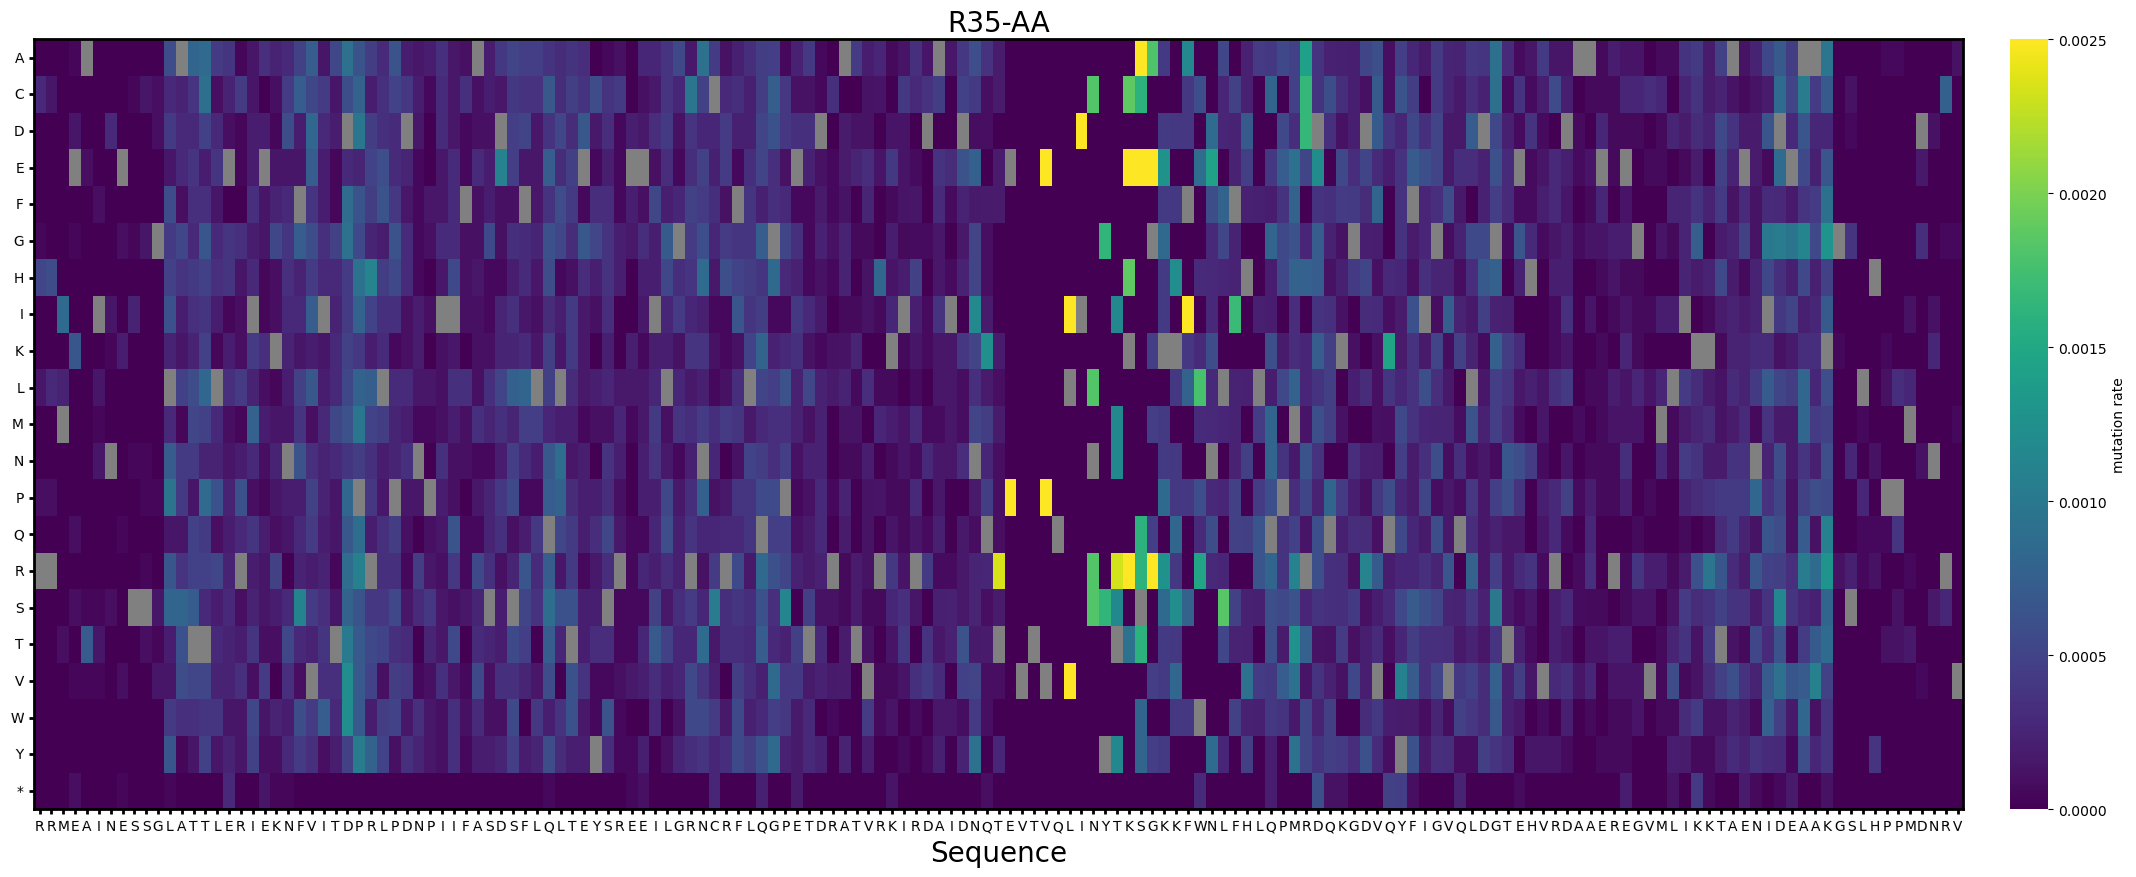

<Figure size 640x480 with 0 Axes>

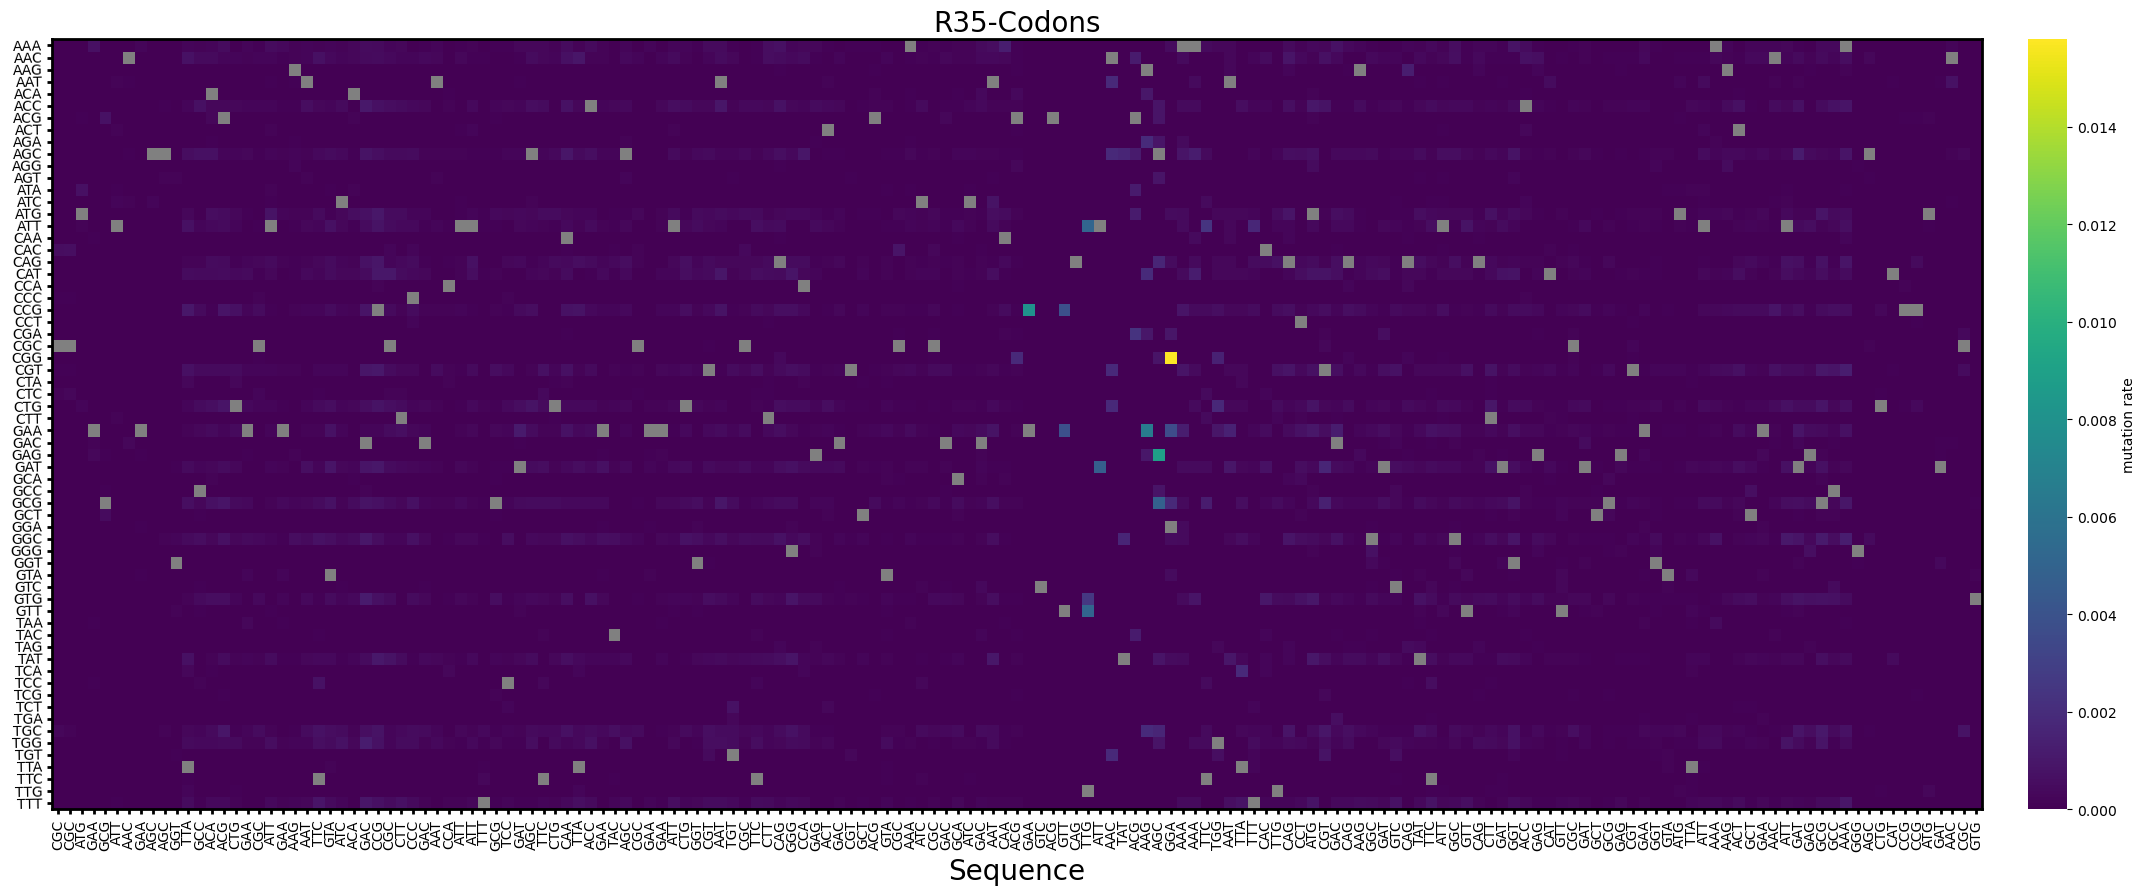

In [223]:
## plot mutation enrichment on DNA, AA and Codon level 
vmax = 0.0025
DNA_counts, DNA_relative = mask_ref_in_variants_df(seq_variants["DNA"], amplicon_DNA,data_type="DNA", reverse = not use_forward_read)
# if not use_forward_read: 
#     DNA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(variants_df=DNA_relative, samplename =  f'{name}-DNA', data_type = "DNA", ref_seq=amplicon_DNA[:DNA_relative.shape[1]], FigFolder=FigFolder, vmax = vmax*2)

AA_counts, AA_relative = mask_ref_in_variants_df(seq_variants["AA"], amplicon_AA,data_type="AA", reverse = not use_forward_read)
plot_mutation_enrichment(variants_df=AA_relative, samplename=f'{name}-AA',ref_seq=amplicon_AA[:AA_relative.shape[1]],data_type = "AA", FigFolder=FigFolder, vmax = vmax)


# AA_counts, AA_relative = mask_ref_in_variants_df(seq_variants["AA"], amplicon_AA,data_type="AA", reverse = not use_forward_read)
# plot_mutation_enrichment(variants_df=AA_relative, samplename=f'{name}-AA',ref_seq=amplicon_AA[:AA_relative.shape[1]],data_type = "AA", FigFolder=FigFolder, vmax = vmax)


Codons_counts, Codons_relative = mask_ref_in_variants_df(seq_variants["Codons"], amplicon_DNA,data_type="Codons", reverse = not use_forward_read)
# if not use_forward_read:
#     Codons_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(variants_df=Codons_relative, samplename=f'{name}-Codons',ref_seq=amplicon_DNA[:DNA_relative.shape[1]],data_type = "Codons",  FigFolder=FigFolder, vmax=None)


In [12]:
os.getcwd()

'/home/student/anna/DMS_analysis'

In [46]:
import json

# Open the JSON file and load it as a dictionary
with open("data/blastdb/R35_BC2_Nt_filt_R1_001.out", "r") as file:
    blast_output = json.load(file)

# Now 'data' is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>

blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()

LOV2_startidx = amplicon_seq.index("ttagccacaa".upper())

<class 'dict'>


In [47]:
### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")
blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= LOV2_startidx-10 and alignment["hsps"][0]["query_to"] >= LOV2_startidx+10]
print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")


32368 alignments before filtering for LOV2 insertion site
27784 alignments after filtering for LOV2 insertion site


In [48]:
linker_alignments = {}
LOV2_alignments = {}
LOV_startseq = "ttagccacaa".upper()
LOV2_start_indel_count = 0

for alignment in blast_alignments:
    qseq = alignment["hsps"][0]["qseq"]
    hseq = alignment["hsps"][0]["hseq"]
    seq_id = alignment["description"][0]["title"]
    midline = alignment["hsps"][0]["midline"]

    cut_site = qseq.find(LOV_startseq)
    if cut_site != -1: ## insertions in start of LOV2, thus seq not in ref seq
        linker_alignments[seq_id] = {"qseq": qseq[:cut_site], "hseq": hseq[:cut_site], "midline": midline[:cut_site]}
        LOV2_alignments[seq_id] = {"qseq": qseq[cut_site:], "hseq": hseq[cut_site:], "midline": midline[cut_site:]}
    else:
        LOV2_start_indel_count +=1

print(LOV2_start_indel_count, "sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)")
    
    

28 sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)


In [49]:
def translate_dna2aa(orf: str) -> str:
  """
  Ignorant DNA to protein translation.
  Stops on anything not from the genetic code and does not check for length.
  """
  protein = ''
  # Interestingly enough timing revealed that bad practices (loops and string addition)
  # resulted in the fastest translation (for a 150 base dummy sequence)
  for i in range(0, (len(orf) // 3) * 3, 3):
    try:
      protein += genetic_code[orf[i:i + 3]]
    except KeyError:
      protein += 'X'
      #break
  return protein

In [50]:
enrichment = {}
seq_with_off_target_indels = 0
short_seq = 0
included_seq = 0
indels = pd.DataFrame(columns = range(len(LOV2_prot)*3), index = ["insertion", "deletion"], data = 0)

for idx in range(len(LOV2_prot)):
        enrichment[idx] = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 
                            'H':0, 'I':0, 'K':0, 'L':0, 'M':0, 'N':0, 
                            'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 
                            'W':0, 'Y':0, '*':0} ## X: are triplets with missing nucleotides (i.e. in the aligned seq, "-" is present), that would lead to a frameshift
        
for x in LOV2_alignments.values():
    qseq = x["qseq"]
    hseq = x["hseq"]
    
    if "-" in hseq or "-" in qseq:
        seq_with_off_target_indels += 1
        for idx,nt in enumerate(hseq): 
            if nt == "-":
                indels.loc["deletion", idx] += 1
        for idx,nt in enumerate(qseq):
            if nt == "-":
                indels.loc["insertion", idx] += 1
             
        continue
    #filtered_hseq = "".join([s2 for s1, s2 in zip(qseq, hseq) if s1 != "-"]) ## filter out gaps that are present in the hseq, to exclude insertions that lead to frameshifts (seq errors or off target insertions)
   

    hseq_AA = translate_dna2aa(hseq)

    if len(hseq_AA) > 10:
        for idx, Aa in enumerate(hseq_AA): 
            enrichment[idx][Aa] += 1
        included_seq +=1
    else: 
        short_seq +=1

print(short_seq, "short sequences (<10 AAs) are excluded")
print(seq_with_off_target_indels, "sequences with off target indels are excluded")
print(included_seq, "sequences are included in the enrichment analysis")


424 short sequences (<10 AAs) are excluded
2237 sequences with off target indels are excluded
25095 sequences are included in the enrichment analysis


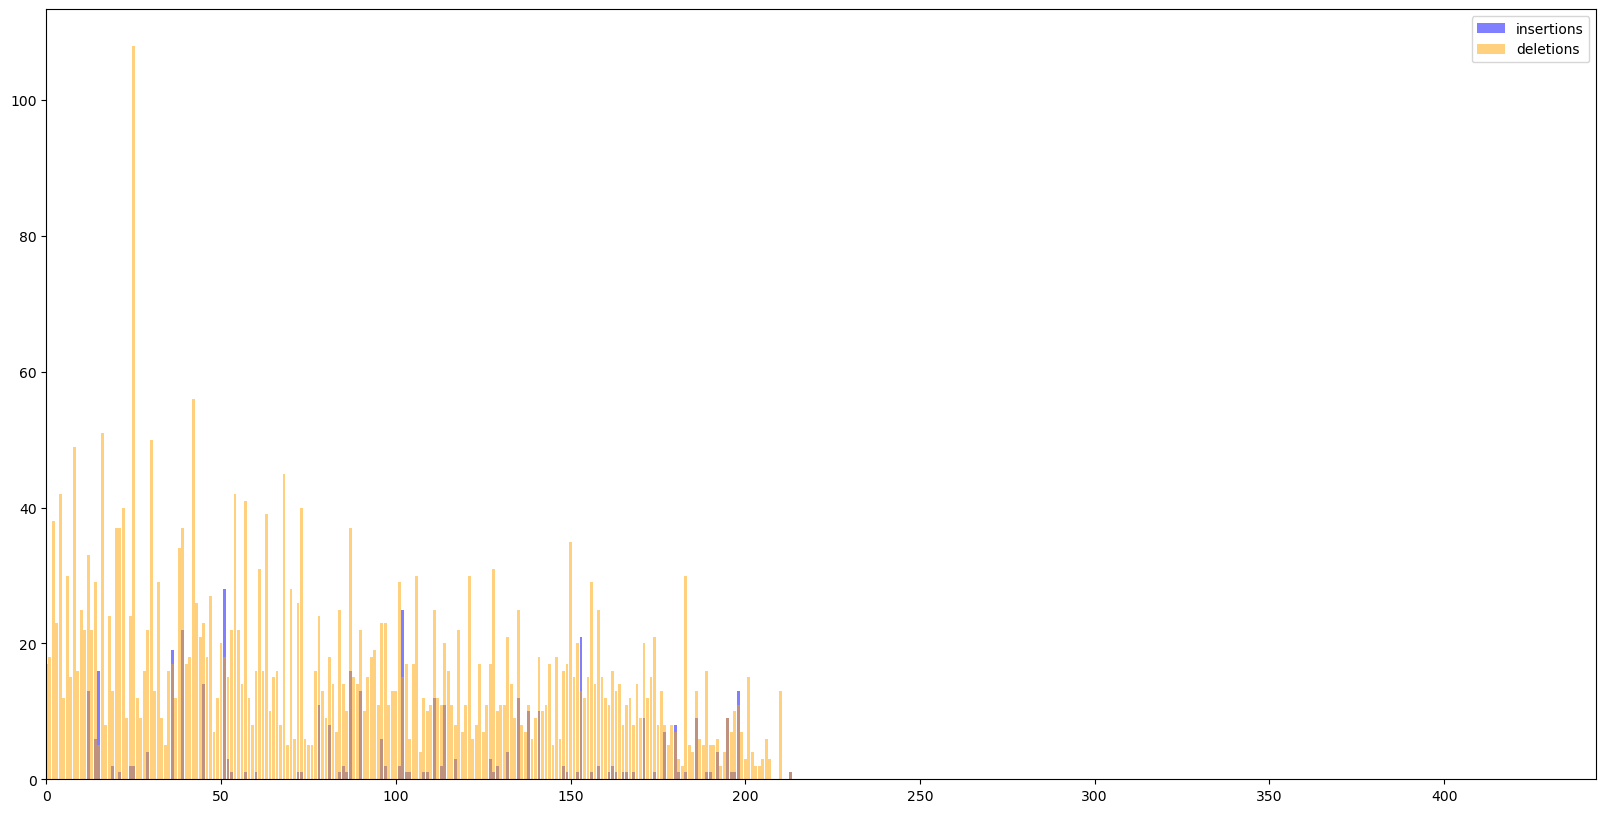

In [51]:
plt.figure(figsize=(20,10))
plt.bar(indels.columns, indels.loc["insertion"], color = "blue", alpha = 0.5, label = "insertions")
plt.bar(indels.columns, indels.loc["deletion"], color = "orange", alpha = 0.5, label = "deletions")
plt.legend()
plt.xlim(0)
plt.show()

In [34]:
enrichment_df = pd.DataFrame.from_dict(enrichment)
enrichment_df = enrichment_df.loc[:,enrichment_df.sum() > 0]
enrichment_counts, enrichment_perc = mask_ref_in_variants_df(enrichment_df, LOV2_prot, data_type="AA")

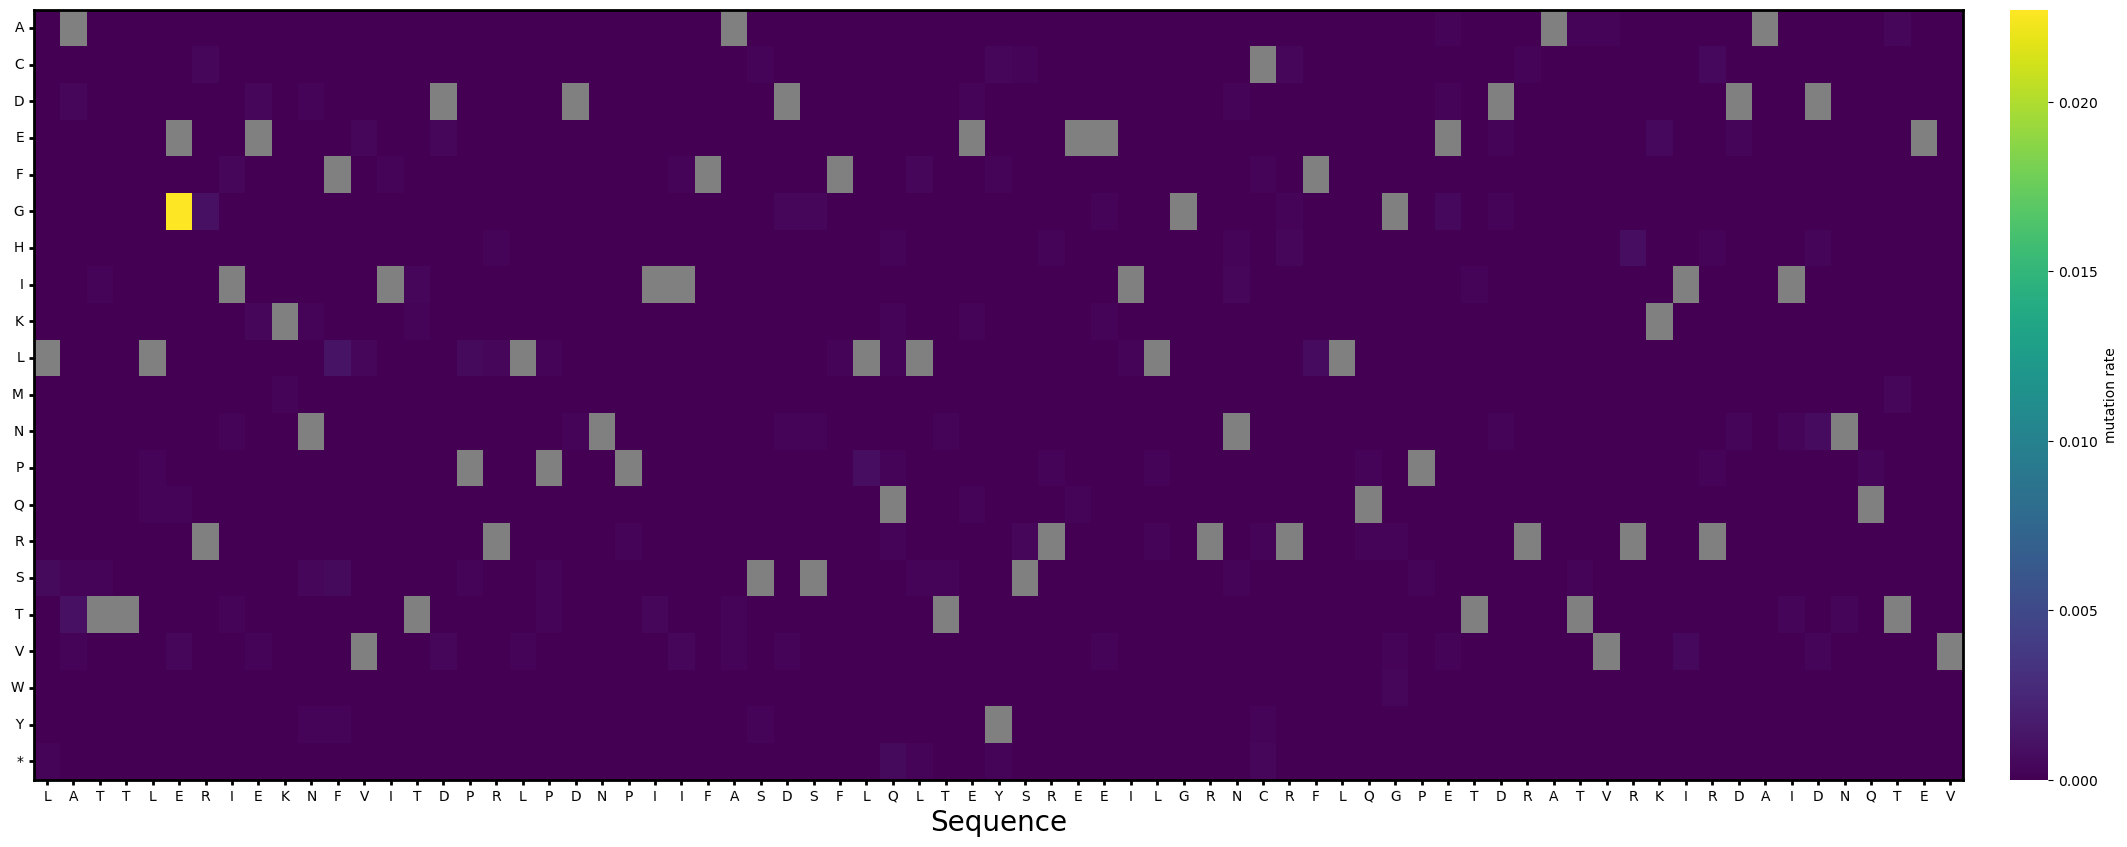

In [35]:
### BC1
plot_mutation_enrichment(enrichment_perc, ref_seq=LOV2_prot[:enrichment_df.shape[1]])

In [36]:
frameshifts = 0
linkers = {}
wt_linker = "SG"

for x in linker_alignments.values():
      qseq = x["qseq"]
      hseq = x["hseq"]

      ##### exclude frameshift reads 
      if qseq.count("-") %3 !=0 or hseq.count("-") %3 !=0: # insertions (shown as "-" in ref) not multiple of three lead to frameshifts -> exclude these reads

            frameshifts += 1

      ##### WT sequences
      elif qseq == hseq: ## WT linkers with differences in the rest of the sequence are taken into account below
                  
                  linkers["wt"] = linkers.get("wt", 0) +1

      ##### reads with deletions 
      elif hseq.count("-") > 0 and hseq.count("-") %3 == 0: ## deletions that are multiple of 3, not leading to frameshifts 

            if hseq.count("-") == 3:  #### 3 deletions represent substitution of SG linker by a single AA, here we might also get some noise, due to sequencing errors that lead to deletions of 3 Nts but this is fine (?)

                  hseq_filt = re.sub("-","", hseq) 
                  linker = translate_dna2aa(hseq_filt)[-len(wt_linker)+1:] ## linker shortened by 3 Nts = 1 AA

                  linkers[linker] = linkers.get(linker, 0) +1
                  

            else: ### deletions in the linker region

                  del_count = hseq.count("-") 
                  
                  delname = "del-"+str(del_count)

                  linkers[delname] = linkers.get(delname, 0) +1

      ###### reads with substitutions 
      elif qseq.count("-") == 0: ### linker was substituted, but no deletions or insertions present

            if hseq[-len(wt_linker)*3:] == qseq[-len(wt_linker)*3:]: ## WT linker (but differences in the rest (e.g beginning) of the sequence, thus these did not meet the first criterium)
                  
                  linkers["wt"] = linkers.get("wt", 0) +1

            else: 

                  linker = translate_dna2aa(hseq)[-len(wt_linker):]
                  linkers[linker] = linkers.get(linker, 0) +1
      
      ###### reads with insertions
      elif qseq.count("-") > 0:

            insertion_len = qseq.count("-")//3 # AA level 
            linker = translate_dna2aa(hseq)[-len(wt_linker)-insertion_len:]
            linkers[linker] = linkers.get(linker, 0) +1

      #### all other reads
      else:
            print("sequence", hseq, "does not meet any criteria")

print(frameshifts, "reads excluded due to frameshifts")

26 reads excluded due to frameshifts


In [37]:
## sort linkers by frequency

linkers_sorted = {k: v for k, v in sorted(linkers.items(), key=lambda item: item[1], reverse=True)}
total_reads = sum(linkers_sorted.values())
linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}

# exclude wt: 
linkers_sorted_perc.pop("wt")
linkers_perc_filt = {k: v for k, v in linkers_sorted_perc.items() if v > 0.05}

In [38]:
sum(linkers_perc_filt.values())

92.31605654222545

<Figure size 640x480 with 0 Axes>

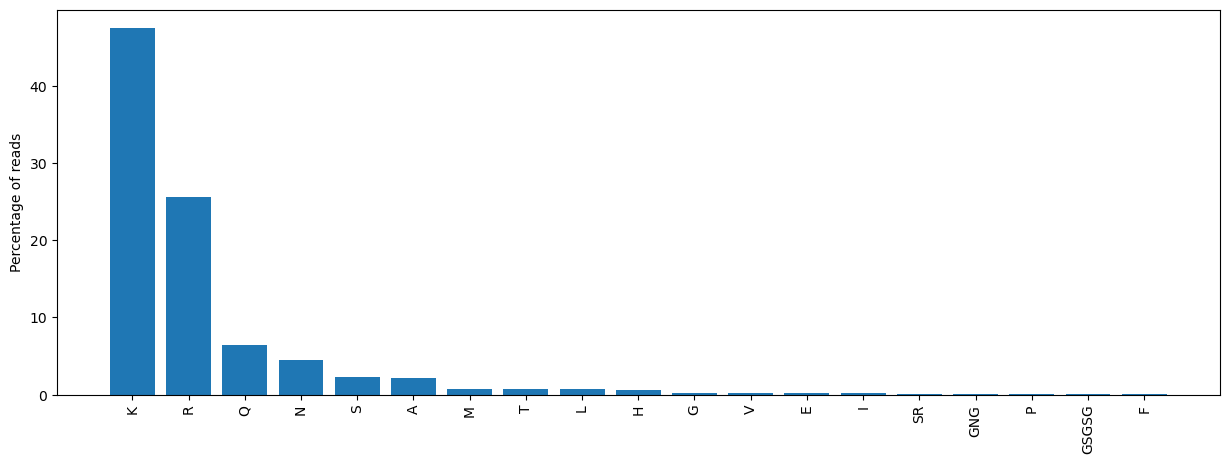

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values())
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.show()

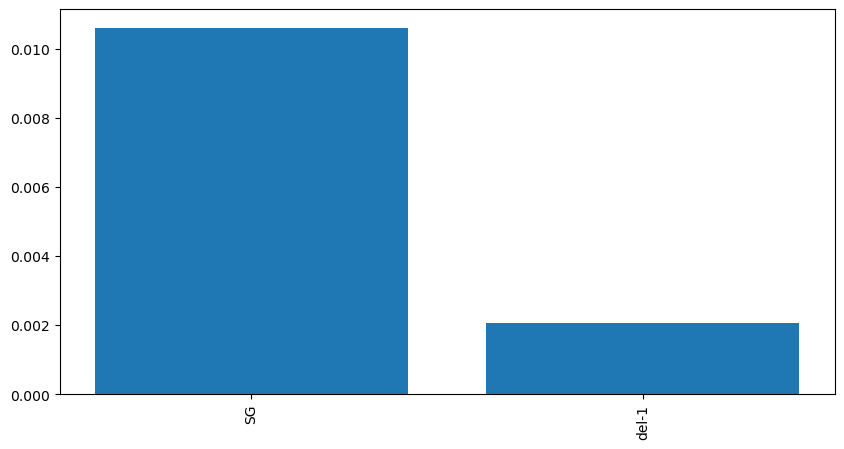

In [219]:
## BC1 -> no linker indels 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values())
plt.xticks(rotation=90)
plt.show()